# Load and Inspect Online Forecast Dataset

This notebook demonstrates how to load and inspect a forecast dataset using the NeuralHydrology config.

In [1]:
import os
os.getcwd()

'/home/sngrj0hn/GitHub/neuralhydrology/operational_harz/gefs_10d_sample'

In [2]:
os.chdir('/home/sngrj0hn/GitHub/neuralhydrology')

In [3]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import timedelta
from pathlib import Path
from neuralhydrology.utils.config import Config
from neuralhydrology.datasetzoo.onlineforecastdataset import OnlineForecastDataset

## Load Configuration

First, let's load the configuration file and examine the key settings.

In [4]:
# Load the config file
config_path = Path('/home/sngrj0hn/GitHub/neuralhydrology/operational_harz/gefs_10d_sample/config.yml')
config = Config(config_path)

## Create Forecast Dataset

Now let's create a ForecastDataset instance and examine its properties.

In [6]:
# Initialize the dataset
dataset = OnlineForecastDataset(cfg=config, is_train=True, period='train')

/home/sngrj0hn/anaconda3/envs/neuralhydrology/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



## Inspect Available Variables

Load the materialized xarray dataset so we can list the variables that made it through the preprocessing pipeline.

In [7]:
# Reconstruct the merged xarray.Dataset directly from the in-memory OnlineForecastDataset
def _to_lookup(source) -> dict[str, float]:
    """Convert scaler entries (xarray.Dataset, dict, or None) into a flat lookup."""
    if source is None:
        return {}
    if isinstance(source, xr.Dataset):
        return {name: float(da.values) for name, da in source.data_vars.items()}
    if isinstance(source, dict):
        lookup: dict[str, float] = {}
        for key, value in source.items():
            arr = np.asarray(value)
            lookup[key] = float(arr.item()) if arr.shape == () else float(arr)
        return lookup
    return {}

centers_lookup = _to_lookup(dataset.scaler.get('xarray_feature_center'))
scales_lookup = _to_lookup(dataset.scaler.get('xarray_feature_scale'))

# Add attribute scalers if available
if 'attribute_means' in dataset.scaler:
    centers_lookup.update(_to_lookup(dataset.scaler['attribute_means']))
if 'attribute_stds' in dataset.scaler:
    scales_lookup.update(_to_lookup(dataset.scaler['attribute_stds']))

freq_key = dataset.frequencies[0] if dataset.frequencies else next(iter(dataset._x_h[dataset.basins[0]]))
basin_id = dataset.basins[0]

# Check if data is torch tensor or numpy array/memmap
def _to_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    return data

hindcast_tensor = _to_numpy(dataset._x_h[basin_id][freq_key])
target_tensor = _to_numpy(dataset._y[basin_id][freq_key])
forecast_tensor = _to_numpy(dataset._x_f[basin_id][freq_key])
time_index = pd.to_datetime(dataset._dates[basin_id][freq_key])
issue_times = pd.to_datetime(dataset._issue_times[basin_id][freq_key])
lead_offsets = np.arange(forecast_tensor.shape[1]) * np.timedelta64(1, 'h')

hindcast_cols = dataset.cfg.hindcast_inputs[:hindcast_tensor.shape[1]]
target_cols = dataset.cfg.target_variables[:target_tensor.shape[1]]
forecast_cols = dataset.cfg.forecast_inputs[:forecast_tensor.shape[2]]

# Get static attributes if available
static_attributes = {}
if hasattr(dataset, '_attributes') and basin_id in dataset._attributes:
    attr_tensor = _to_numpy(dataset._attributes[basin_id])
    attr_names = dataset.cfg.static_attributes
    if len(attr_names) == len(attr_tensor):
        # Restore attributes
        restored_attrs = []
        for idx, name in enumerate(attr_names):
            center = centers_lookup.get(name, 0.0)
            scale = scales_lookup.get(name, 1.0)
            val = attr_tensor[idx] * scale + center
            static_attributes[name] = float(val)

def _restore(values: np.ndarray, names: list[str]) -> np.ndarray:
    restored = values.copy()
    for idx, name in enumerate(names):
        center = centers_lookup.get(name, 0.0)
        scale = scales_lookup.get(name, 1.0)
        restored[..., idx] = values[..., idx] * scale + center
    return restored

hindcast_raw = _restore(hindcast_tensor, hindcast_cols)
target_raw = _restore(target_tensor, target_cols) if target_cols else np.empty((hindcast_raw.shape[0], 0))
forecast_raw = _restore(forecast_tensor, forecast_cols)

datasets_to_merge: list[xr.Dataset] = []
if hindcast_cols:
    hindcast_da = xr.DataArray(
        hindcast_raw[np.newaxis, :, :],
        coords={'basin': [basin_id], 'time': time_index, 'hindcast_variable': hindcast_cols},
        dims=('basin', 'time', 'hindcast_variable'),
    ).to_dataset(dim='hindcast_variable')
    datasets_to_merge.append(hindcast_da)
if target_cols:
    target_da = xr.DataArray(
        target_raw[np.newaxis, :, :],
        coords={'basin': [basin_id], 'time': time_index, 'target_variable': target_cols},
        dims=('basin', 'time', 'target_variable'),
    ).to_dataset(dim='target_variable')
    datasets_to_merge.append(target_da)
if forecast_cols:
    forecast_da = xr.DataArray(
        forecast_raw[np.newaxis, :, :, :],
        coords={
            'basin': [basin_id],
            'issue_time': issue_times,
            'lead_time': lead_offsets,
            'forecast_variable': forecast_cols,
        },
        dims=('basin', 'issue_time', 'lead_time', 'forecast_variable'),
    ).to_dataset(dim='forecast_variable')
    datasets_to_merge.append(forecast_da)

xr_dataset = xr.merge(datasets_to_merge)

# Add static attributes to the dataset
for name, val in static_attributes.items():
    xr_dataset[name] = (('basin',), [val])

dims = dict(xr_dataset.sizes)
hist_vars = sorted([var for var in xr_dataset.data_vars if 'lead_time' not in xr_dataset[var].dims and 'time' in xr_dataset[var].dims])
forecast_vars = sorted([var for var in xr_dataset.data_vars if 'lead_time' in xr_dataset[var].dims])
static_vars = sorted([var for var in xr_dataset.data_vars if 'time' not in xr_dataset[var].dims and 'issue_time' not in xr_dataset[var].dims])

print('Dimensions:')
for name, size in dims.items():
    print(f'  {name}: {size}')

print('\nHistorical variables (no lead_time dimension):')
for var in hist_vars:
    print(f'  - {var}')

print('\nForecast variables (with lead_time dimension):')
for var in forecast_vars:
    print(f'  - {var}')

print('\nStatic attributes:')
for var in static_vars:
    val = xr_dataset[var].values[0]
    print(f'  - {var}: {val:.4f}')

Dimensions:
  basin: 1
  time: 32112
  issue_time: 1095
  lead_time: 240

Historical variables (no lead_time dimension):
  - dew_point_2m
  - discharge_vol
  - et0_fao_evapotranspiration
  - precipitation
  - rain
  - relative_humidity_2m
  - shortwave_radiation
  - snowfall
  - soil_moisture_0_to_7cm
  - soil_moisture_28_to_100cm
  - soil_moisture_7_to_28cm
  - surface_pressure
  - temperature_2m
  - wind_direction_10m

Forecast variables (with lead_time dimension):
  - maximum_temperature_2m_q25
  - maximum_temperature_2m_q50
  - maximum_temperature_2m_q75
  - minimum_temperature_2m_q25
  - minimum_temperature_2m_q50
  - minimum_temperature_2m_q75
  - precipitation_surface_q25
  - precipitation_surface_q50
  - precipitation_surface_q75
  - relative_humidity_2m_q25
  - relative_humidity_2m_q50
  - relative_humidity_2m_q75
  - temperature_2m_q25
  - temperature_2m_q50
  - temperature_2m_q75

Static attributes:
  - agricultural_areas_perc: 0.4196
  - aquifer_perc: 0.3633
  - aquitard_pe

## Plot Historical and Forecast Time Series

Visualize temperature and precipitation for the most recent forecast issue to mirror the operational overview.

In [8]:
# Summarize temporal coverage across historical and forecast dimensions
time_coord = xr_dataset.coords.get('time')
if time_coord is None or time_coord.size == 0:
    print('No historical time coordinate present.')
else:
    hist_times = pd.to_datetime(time_coord.values)
    print('Historical coverage:')
    print(f"  start: {pd.Timestamp(hist_times.min())}")
    print(f"  end:   {pd.Timestamp(hist_times.max())}")
    print(f"  total steps: {hist_times.size}")
issue_coord = xr_dataset.coords.get('issue_time')
if issue_coord is None or issue_coord.size == 0:
    print('\nNo forecast issue_time coordinate present.')
else:
    issue_times = np.sort(pd.to_datetime(issue_coord.values))
    print('\nForecast issue coverage:')
    print(f"  first issue: {pd.Timestamp(issue_times[0])}")
    print(f"  last issue:  {pd.Timestamp(issue_times[-1])}")
    if issue_times.size > 1:
        diffs = pd.Series(issue_times).sort_values().diff().dropna()
        if not diffs.empty:
            print(f"  median spacing: {diffs.median()}")
    print(f"  total issues: {issue_times.size}")
    head_count = min(3, issue_times.size)
    tail_count = min(3, issue_times.size)
    print('  sample issues (first):')
    for ts in issue_times[:head_count]:
        print(f'    - {pd.Timestamp(ts)}')
    if issue_times.size > head_count:
        print('  sample issues (last):')
        for ts in issue_times[-tail_count:]:
            print(f'    - {pd.Timestamp(ts)}')
lead_coord = xr_dataset.coords.get('lead_time')
if lead_coord is None or lead_coord.size == 0:
    print('\nNo lead_time coordinate present.')
else:
    lead_values = pd.to_timedelta(lead_coord.values)
    print('\nForecast lead coverage:')
    print(f"  min lead: {lead_values.min()}")
    print(f"  max lead: {lead_values.max()}")
    print(f"  total leads: {lead_values.size}")

Historical coverage:
  start: 2020-09-01 00:00:00
  end:   2024-04-30 23:00:00
  total steps: 32112

Forecast issue coverage:
  first issue: 2020-10-01 00:00:00
  last issue:  2023-09-30 00:00:00
  median spacing: 1 days 00:00:00
  total issues: 1095
  sample issues (first):
    - 2020-10-01 00:00:00
    - 2020-10-02 00:00:00
    - 2020-10-03 00:00:00
  sample issues (last):
    - 2023-09-28 00:00:00
    - 2023-09-29 00:00:00
    - 2023-09-30 00:00:00

Forecast lead coverage:
  min lead: 0 days 00:00:00
  max lead: 9 days 23:00:00
  total leads: 240


Plotting basin: DE1
Using forecast initialization time: 2023-09-30 00:00:00


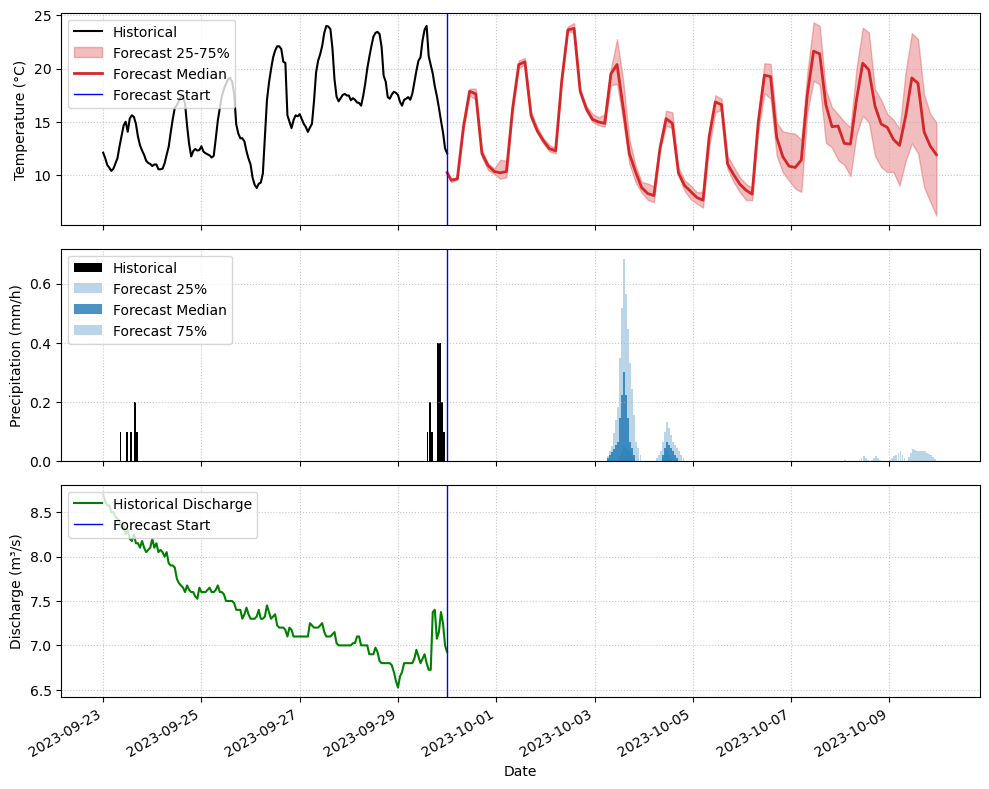

In [9]:
# Plot temperature, precipitation, and discharge around the target forecast issue
from matplotlib import dates as mdates

TARGET_BASIN = 'DE2'
TARGET_INIT_TIME = pd.Timestamp('2023-12-23 00:00:00')
HISTORICAL_DAYS = 7
MM_PER_S_TO_MM_PER_HR = 3600.0

available_basins = [str(b) for b in xr_dataset['basin'].values]
basin_id = TARGET_BASIN if TARGET_BASIN in available_basins else available_basins[0]
print(f'Plotting basin: {basin_id}')

basin_ds = xr_dataset.sel(basin=basin_id)

def _prefixed(prefix: str, candidates: list[str]) -> list[str]:
    return [name for name in candidates if name.startswith(prefix)]

temp_hist_var = next((name for name in hist_vars if name.startswith('temperature_2m')), None)
prec_hist_var = next((name for name in hist_vars if name.startswith('precipitation')), None)
discharge_hist_var = next((name for name in hist_vars if name.startswith('discharge')), None)
if not all([temp_hist_var, prec_hist_var, discharge_hist_var]):
    raise ValueError('Could not find required historical variables (temperature, precipitation, discharge).')

temp_fcst_candidates = _prefixed('temperature_2m', forecast_vars)
temp_q25_var = next((name for name in temp_fcst_candidates if name.endswith('_q25')), None)
temp_q50_var = next((name for name in temp_fcst_candidates if name.endswith('_q50')), None)
temp_q75_var = next((name for name in temp_fcst_candidates if name.endswith('_q75')), None)
prec_fcst_candidates = _prefixed('precipitation', forecast_vars)
prec_q25_var = next((name for name in prec_fcst_candidates if name.endswith('_q25')), None)
prec_q50_var = next((name for name in prec_fcst_candidates if name.endswith('_q50')), None)
prec_q75_var = next((name for name in prec_fcst_candidates if name.endswith('_q75')), None)
if not all([temp_q25_var, temp_q50_var, temp_q75_var, prec_q25_var, prec_q50_var, prec_q75_var]):
    raise ValueError('Expected forecast quantiles (_q25/_q50/_q75) for temperature and precipitation are missing.')

issue_candidates = pd.to_datetime(basin_ds[temp_q50_var]['issue_time'].values)
if issue_candidates.size == 0:
    raise ValueError('No forecast issue times available for plotting.')
if TARGET_INIT_TIME is not None:
    diffs = np.abs(issue_candidates - TARGET_INIT_TIME)
    closest_idx = int(diffs.argmin())
    issue_datetime = pd.Timestamp(issue_candidates[closest_idx])
else:
    issue_datetime = pd.Timestamp(issue_candidates[-1])
print(f'Using forecast initialization time: {issue_datetime}')
issue_np = np.datetime64(issue_datetime)

hist_start = issue_datetime - pd.Timedelta(days=HISTORICAL_DAYS)
temp_hist = basin_ds[temp_hist_var].sel(time=slice(hist_start, issue_datetime)).to_series().dropna()
prec_hist = basin_ds[prec_hist_var].sel(time=slice(hist_start, issue_datetime)).to_series().dropna()
discharge_hist = basin_ds[discharge_hist_var].sel(time=slice(hist_start, issue_datetime)).to_series().dropna()

if len(temp_hist.index) == 0 or len(prec_hist.index) == 0 or len(discharge_hist.index) == 0:
    raise ValueError('Insufficient historical data for the requested plotting window.')

# Extract forecast data for the selected issue time
temp_q25_da = basin_ds[temp_q25_var].sel(issue_time=issue_np)
temp_q50_da = basin_ds[temp_q50_var].sel(issue_time=issue_np)
temp_q75_da = basin_ds[temp_q75_var].sel(issue_time=issue_np)
prec_q25_da = basin_ds[prec_q25_var].sel(issue_time=issue_np)
prec_q50_da = basin_ds[prec_q50_var].sel(issue_time=issue_np)
prec_q75_da = basin_ds[prec_q75_var].sel(issue_time=issue_np)

lead_times = pd.to_timedelta(temp_q50_da['lead_time'].values)
forecast_index = issue_datetime + lead_times

forecast_temp = {
    'q25': pd.Series(temp_q25_da.values, index=forecast_index).dropna(),
    'q50': pd.Series(temp_q50_da.values, index=forecast_index).dropna(),
    'q75': pd.Series(temp_q75_da.values, index=forecast_index).dropna(),
}
forecast_prec = {
    'q25': pd.Series(prec_q25_da.values * MM_PER_S_TO_MM_PER_HR, index=forecast_index).dropna(),
    'q50': pd.Series(prec_q50_da.values * MM_PER_S_TO_MM_PER_HR, index=forecast_index).dropna(),
    'q75': pd.Series(prec_q75_da.values * MM_PER_S_TO_MM_PER_HR, index=forecast_index).dropna(),
}
forecast_time_axis = forecast_temp['q50'].index

if len(prec_hist.index) > 1:
    hist_bar_width_days = (prec_hist.index[1] - prec_hist.index[0]).total_seconds() / (24 * 3600)
else:
    hist_bar_width_days = 1 / 24
if len(forecast_time_axis) > 1:
    forecast_bar_width_days = (forecast_time_axis[1] - forecast_time_axis[0]).total_seconds() / (24 * 3600)
else:
    forecast_bar_width_days = 1 / 24

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
ax_temp, ax_prec, ax_q = axes

# Temperature subplot
q25_temp = forecast_temp['q25'].reindex(forecast_time_axis)
q50_temp = forecast_temp['q50'].reindex(forecast_time_axis)
q75_temp = forecast_temp['q75'].reindex(forecast_time_axis)
ax_temp.plot(temp_hist.index, temp_hist.values, color='black', label='Historical')
ax_temp.fill_between(forecast_time_axis, q25_temp.values, q75_temp.values,
                     color='#d62728', alpha=0.3, label='Forecast 25-75%')
ax_temp.plot(forecast_time_axis, q50_temp.values, color='#d62728', linestyle='-', linewidth=2,
             label='Forecast Median')
ax_temp.axvline(issue_datetime, color='blue', linestyle='-', linewidth=1, label='Forecast Start')
ax_temp.set_ylabel('Temperature (°C)')
ax_temp.legend(loc='upper left')
ax_temp.grid(True, linestyle=':', alpha=0.7)

# Precipitation subplot
ax_prec.bar(prec_hist.index, prec_hist.values, width=hist_bar_width_days * 0.9, color='black', align='edge', label='Historical')
quartile_alphas = {'q25': 0.3, 'q50': 0.8, 'q75': 0.3}
quartile_labels = {'q25': 'Forecast 25%', 'q50': 'Forecast Median', 'q75': 'Forecast 75%'}
for quartile, series in forecast_prec.items():
    series = series.reindex(forecast_time_axis)
    ax_prec.bar(series.index, series.values, width=forecast_bar_width_days * 0.9, color='#1f77b4', align='edge',
                alpha=quartile_alphas[quartile], label=quartile_labels[quartile])
ax_prec.axvline(issue_datetime, color='blue', linestyle='-', linewidth=1)
ax_prec.set_ylabel('Precipitation (mm/h)')
ax_prec.legend(loc='upper left')
ax_prec.grid(True, linestyle=':', alpha=0.7)

# Discharge subplot
ax_q.plot(discharge_hist.index, discharge_hist.values, color='green', linewidth=1.5, label='Historical Discharge')
ax_q.axvline(issue_datetime, color='blue', linestyle='-', linewidth=1, label='Forecast Start')
ax_q.set_ylabel('Discharge (m³/s)')
ax_q.legend(loc='upper left')
ax_q.grid(True, linestyle=':', alpha=0.7)

axes[-1].set_xlabel('Date')
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()